In [7]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv("/Users/yecortez/Downloads/credit_card_transactions.csv",
                   parse_dates=["trans_date_trans_time"])

# Convertir la fecha en índice
df = df.sort_values("trans_date_trans_time")
df.set_index("trans_date_trans_time", inplace=True)


In [8]:
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["dayofweek"] = df.index.dayofweek  # Lunes=0, Domingo=6
df["hour"] = df.index.hour  # Para análisis por hora

In [30]:
df_daily = df.resample("D").agg({"amt": "sum", "cc_num": "count"})  # Total de monto, transacciones por día
df_daily.rename(columns={"cc_num": "num_transactions"}, inplace=True)
df_daily = df_daily.fillna(0)  # Llenar valores nulos

In [31]:
df_daily

,amt,num_transactions
trans_date_trans_time,,
2019-01-01,156487.09,2414
2019-01-02,70723.58,1118
2019-01-03,86516.49,1236
2019-01-04,112436.39,1474
2019-01-05,97496.13,1409
...,...,...
2020-06-17,141792.48,1812
2020-06-18,166713.71,2028
2020-06-19,176152.74,2413


In [32]:
for lag in range(1, 8):  # Lags de los últimos 7 días
    df_daily[f"lag_{lag}"] = df_daily["amt"].shift(lag)

df_daily.dropna(inplace=True)  # Eliminar primeras filas con valores nulos


In [33]:
df_daily

,amt,num_transactions,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
trans_date_trans_time,,,,,,,,,
2019-01-08,168061.93,2314,178233.18,135816.21,97496.13,112436.39,86516.49,70723.58,156487.09
2019-01-09,88906.06,1158,168061.93,178233.18,135816.21,97496.13,112436.39,86516.49,70723.58
2019-01-10,87716.01,1249,88906.06,168061.93,178233.18,135816.21,97496.13,112436.39,86516.49
2019-01-11,108301.60,1439,87716.01,88906.06,168061.93,178233.18,135816.21,97496.13,112436.39
2019-01-12,103636.58,1456,108301.60,87716.01,88906.06,168061.93,178233.18,135816.21,97496.13
...,...,...,...,...,...,...,...,...,...
2020-06-17,141792.48,1812,259567.11,296172.66,239596.41,165243.19,162727.24,168896.63,128413.47
2020-06-18,166713.71,2028,141792.48,259567.11,296172.66,239596.41,165243.19,162727.24,168896.63
2020-06-19,176152.74,2413,166713.71,141792.48,259567.11,296172.66,239596.41,165243.19,162727.24


In [34]:
from sklearn.model_selection import train_test_split

# Definir variables independientes (X) y variable objetivo (y)
X = df_daily.drop(columns=["amt"])
y = df_daily["amt"]

# Dividir en conjunto de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # No hacemos shuffle porque es serie temporal

In [39]:
y

trans_date_trans_time
2019-01-08    168061.93
2019-01-09     88906.06
2019-01-10     87716.01
2019-01-11    108301.60
2019-01-12    103636.58
                ...    
2020-06-17    141792.48
2020-06-18    166713.71
2020-06-19    176152.74
2020-06-20    172070.93
2020-06-21    104241.26
Freq: D, Name: amt, Length: 531, dtype: float64

In [42]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear modelo XGBoost
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenar modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluar modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# Calcular R²
r2 = r2_score(y_test, y_pred)

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


R²: 0.9645
MAE: 7661.15, RMSE: 9819.57


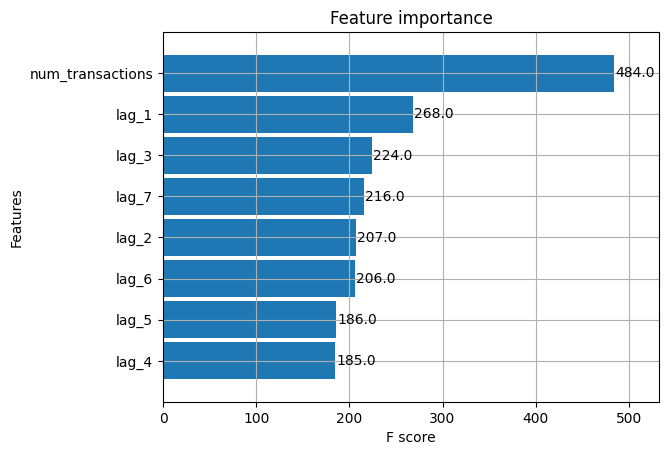

In [46]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(model, height=0.9)

In [70]:
future_days = 90  # Predecir 90 días
last_data = df_daily.iloc[-90:].copy()

predictions = []
for _ in range(future_days):
    pred = model.predict(last_data.drop(columns=["amt"]))[0]
    predictions.append(pred)
    
    # Actualizar datos con la nueva predicción
    last_data = last_data.shift(-1)
    last_data.iloc[-1, last_data.columns.get_loc("amt")] = pred
    
print("Predicciones para los próximos días:", predictions)


Predicciones para los próximos días: [228898.61, 107504.4, 116822.2, 128371.0, 126850.32, 187169.8, 223288.92, 206866.34, 115004.414, 119523.65, 130697.55, 135264.94, 189767.4, 227513.94, 233948.42, 98284.7, 117627.66, 135877.4, 127647.125, 189563.27, 228613.19, 216046.77, 104678.43, 117419.23, 136399.47, 124591.91, 192584.48, 230159.17, 217985.52, 105777.45, 119798.41, 129202.266, 126821.24, 188238.25, 211660.67, 216713.16, 110044.516, 123419.33, 131081.62, 125137.39, 183271.25, 214282.11, 218781.8, 107848.74, 123390.375, 138982.95, 130114.75, 193041.81, 219819.06, 214758.11, 109259.734, 122387.47, 134259.45, 130852.09, 195817.92, 207920.45, 207958.69, 96385.59, 119744.7, 135004.17, 138762.53, 224565.67, 277445.53, 263774.56, 122129.49, 142527.48, 160632.05, 171181.8, 227372.38, 278723.94, 275932.88, 131011.93, 136935.23, 169240.38, 170700.81, 229569.61, 285679.5, 270699.6, 129093.14, 137035.34, 173852.27, 155490.8, 236777.34, 291202.1, 272519.38, 122600.05, 146663.53, 175038.16, 1635

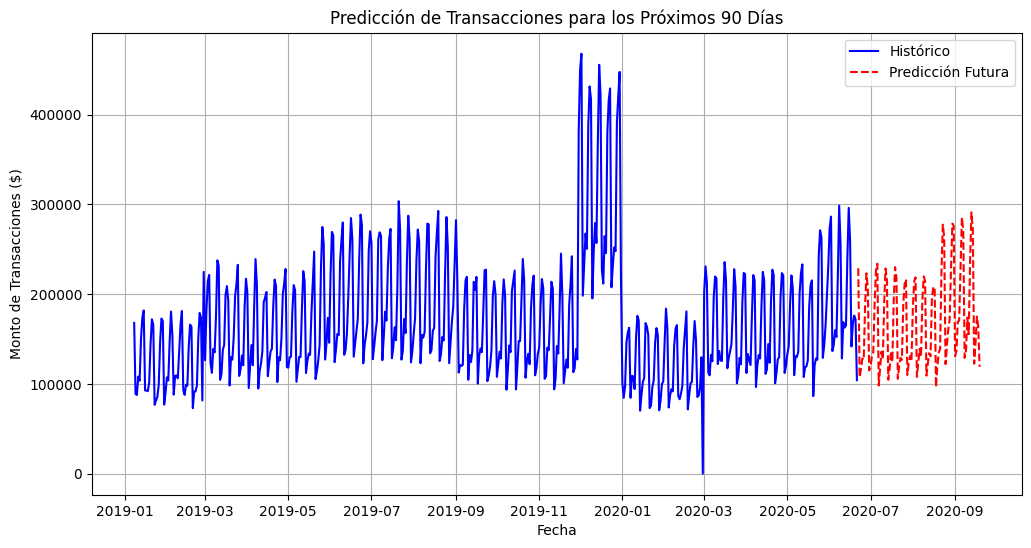

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generar fechas para los próximos 7 días
future_dates = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days, freq="D")

# Crear DataFrame con predicciones
future_df = pd.DataFrame({"Fecha": future_dates, "Predicción": predictions})

# Graficar
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_daily.index, y=df_daily["amt"], label="Histórico", color="blue")
sns.lineplot(x=future_df["Fecha"], y=future_df["Predicción"], label="Predicción Futura", color="red", linestyle="dashed")

# Personalizar gráfico
plt.title("Predicción de Transacciones para los Próximos 90 Días")
plt.xlabel("Fecha")
plt.ylabel("Monto de Transacciones ($)")
plt.legend()
plt.grid(True)
plt.show()

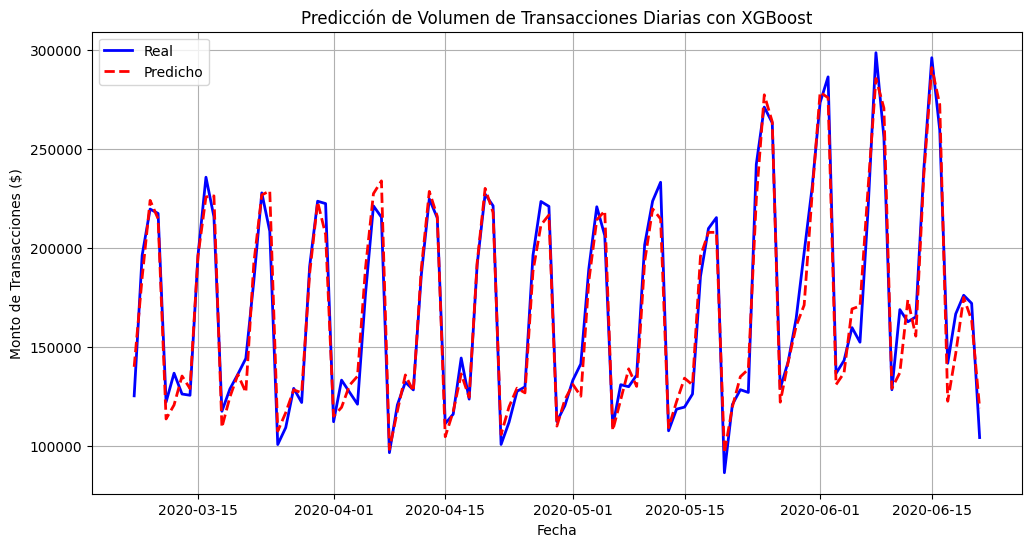

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame con resultados
result_df = pd.DataFrame({"Fecha": X_test.index, "Real": y_test, "Predicho": y_pred})

# Graficar
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_df, x="Fecha", y="Real", label="Real", linewidth=2, color="blue")
sns.lineplot(data=result_df, x="Fecha", y="Predicho", label="Predicho", linewidth=2, color="red", linestyle="dashed")

# Personalizar gráfico
plt.title("Predicción de Volumen de Transacciones Diarias con XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Monto de Transacciones ($)")
plt.legend()
plt.grid(True)
plt.show()
